In [152]:

import numpy as np
import pandas as pd
import scipy.stats
from statsmodels.stats import weightstats
from statsmodels.stats import proportion
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [153]:
data = pd.read_csv('credit_card_default_analysis.csv', sep = '\n', delimiter=",", header = 0)

In [154]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Задание 1
Размер кредитного лимита (LIMIT_BAL): Проверьте гипотезу о равенстве медиан распределений значений кредитного лимита с помощью интервальной оценки и с помощью одного из подходящих непараметрических тестов проверки равенства средних в двух выборках: тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1). Значимы ли полученные результаты с практической точки зрения ?

In [155]:
#Разделим данные на тех кто вернул деньги и на тех, кто - нет
data_def0 = data[data.default==0]
data_def1 = data[data.default==1]

Построим гистограммы для признака LIMIT_BAL в выборках кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1). А также расчитаем медианы распределений и значимость этого результата

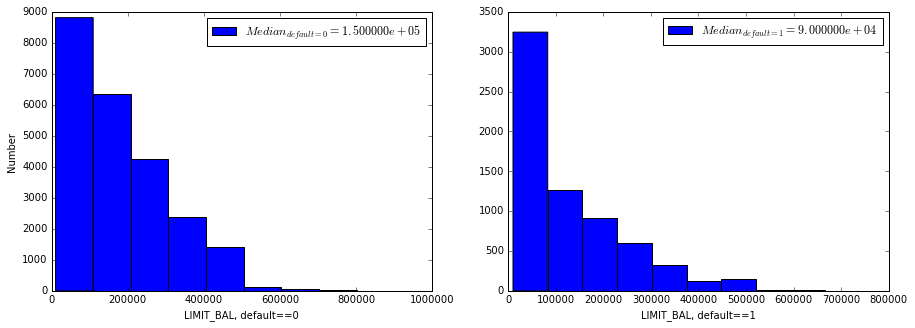

In [156]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(data_def0.LIMIT_BAL , label='$Median_{default=0} = %e$'%data_def0.LIMIT_BAL.median())
plt.xlabel('LIMIT_BAL, default==0')
plt.ylabel('Number')
plt.legend(loc='best')



plt.subplot(1,2,2)
plt.hist(data_def1.LIMIT_BAL, label='$Median_{default=1} = %e$'%data_def1.LIMIT_BAL.median())
plt.xlabel('LIMIT_BAL, default==1')
plt.legend(loc='best')

In [157]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha = 0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [158]:
def0_medians = np.median(get_bootstrap_samples(data_def0.LIMIT_BAL.values, 1000), axis=1)
def1_medians = np.median(get_bootstrap_samples(data_def1.LIMIT_BAL.values, 1000), axis=1)
delta_median = map(lambda x: x[0] - x[1], zip(def0_medians, def1_medians))
print ("95% confidence interval for default=0 median:",  stat_intervals(def0_medians))
print ("95% confidence interval for default=1 median:",  stat_intervals(def1_medians))
print ("95% confidence interval for difference median:",  stat_intervals(delta_median))

('95% confidence interval for default=0 median:', array([ 150000.,  150000.]))
('95% confidence interval for default=1 median:', array([ 80000.,  90000.]))
('95% confidence interval for difference median:', array([ 60000.,  70000.]))


# Ответ: 
Согласно полученному доверительному интервалу разницы медиан, гипотеза об одинаковости медианных значений можно уверенно отвергнуть, поскольку полученный интервал не содержит "0"


In [159]:
from collections import namedtuple
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = scipy.stats.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = scipy.stats.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * scipy.stats.distributions.norm.sf(abs(z))
    else:
        p = scipy.stats.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)

print mannwhitneyu(data_def0.LIMIT_BAL.values, data_def1.LIMIT_BAL.values, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)


# Ответ: 
Полученное значение P-value с помощью книтерия Манна-Уитни дает право с уверенностью отвергнуть нулевую гипотезу о том, что два распределения являются потомками одной генеральной совокупности. Аналитикам банка следует осторожнее относиться к должникам и учитывать их при построении своих финансовых моделей.


# Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [160]:
male_default = data[data.SEX==1].default
female_default = data[data.SEX==2].default

In [161]:
float (sum(male_default.values))/male_default.values.shape[0]

0.2416722745625841

In [162]:
float (sum(female_default.values))/female_default.values.shape[0]

0.20776280918727916

Получается, что вероятность невозрата кредита для мужчины оказывается выше, чем веоятность невозрата кредита для женщины. Давайте разберемся, наскоколько этот результат статистически значим

## Оценим интервально доли веротятности дефолта для мужчин и женщин

In [163]:
print '95%% confidence interval of probability for Men,  who did not return loans: [%f, %f]' % proportion_confint(male_default.sum(), 
                                            male_default.shape[0],
                                            method = 'wilson')
print '95%% confidence interval of probability for Women,  who did not return loans: [%f, %f]' % proportion_confint(female_default.sum(), 
                                            female_default.shape[0],
                                            method = 'wilson')

95% confidence interval of probability for Men,  who did not return loans: [0.234061, 0.249450]
95% confidence interval of probability for Women,  who did not return loans: [0.201917, 0.213733]


### Получились непересекающиеся интервалы для долей. Убедимся в статистической значимости различия. Воспользуемся  Z-критерием для разности долей двух независимых выборок

In [164]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [165]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(male_default.values, female_default.values))
print ("p-value: %e" % proportions_diff_z_test(proportions_diff_z_stat_ind(male_default.values, female_default.values)))

95% confidence interval for a difference between proportions: [0.024207, 0.043612]
p-value: 4.472867e-12


## Ответ:
Полученный доверительный интервал для разности долей, а также p-value дают возможность с уверенностью отвергнуть нулевую гипотезу об одинаковости вероятности дефолта для мужчин и женщин. Полученный результат полезен для построения скоринговой модели.

# Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

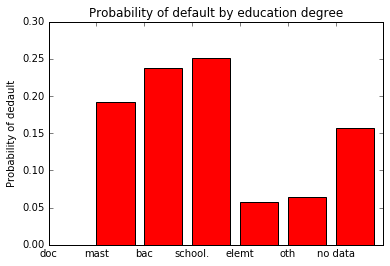

In [166]:
education = [data[data.EDUCATION==i] for i in xrange(7)]

x_names = ['doc', 'mast', 'bac', 'school.', 'elemt', 'oth', 'no data']
position = np.arange(len(x_names))

performance = [data[data.EDUCATION==i].default.mean() for i in xrange(7)]
 
plt.bar(position, performance, color = 'r')
plt.xticks(position , x_names)
plt.ylabel('Probability of dedault')
plt.title('Probability of default by education degree')

## Ответ:
Судя по данным, люди с докторской степенью чаще, чем другие отдают свои долги. Хуже всего отдают свои долги люди имеющие только школьное образование. 


Проверим, влияет ли на нашу целевую переменную default наличие образования у рассматриваемых людей. Применим критерий хи-квадрат для таблиц сопряженности на гипотезу о зависимости между образовинем и возратом кредита, против обратной альтернативы.

In [167]:
contingency_table = np.zeros((7,2))

for i in range(7):
    contingency_table[i, 0] = np.sum(education[i].default==0)
    contingency_table[i, 1] = np.sum(education[i].default==1)
    
chi2, pvalue, dof, ex = scipy.stats.chi2_contingency(contingency_table)    
print ("p-value: %e" % pvalue)

p-value: 1.233263e-32


## Ответ:
Нулевая гипотеза о независимости уверенно отвергается.

# Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [168]:
mariage = [data[data.MARRIAGE==i] for i in range(4)]

contingency_table = np.zeros((4,2))

for i in range(4):
    contingency_table[i, 0] = np.sum(mariage[i].default==0)
    contingency_table[i, 1] = np.sum(mariage[i].default==1)
    
chi2, pvalue, dof, ex = scipy.stats.chi2_contingency(contingency_table)    
print ("p-value: %e" % pvalue)
print('V Cramer %e' % np.sqrt(chi2/(np.sum(contingency_table)*min(contingency_table.shape[0]-1, contingency_table.shape[1]-1))))

p-value: 8.825862e-08
V Cramer 3.447820e-02


## Ответ:
Нулевая гипотеза о независимости вероятности возрата кредита и статуса семейного положения уверенно отвергается. Мерой этой связи является абсолютное значение коэффициента V Крамера

# Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [169]:
#Разделим данные на тех кто вернул деньги и на тех, кто - нет
data_def0 = data[data.default==0]
data_def1 = data[data.default==1]

Построим гистограммы для признака AGE в выборках кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1). А также расчитаем медианы распределений и значимость этого результата

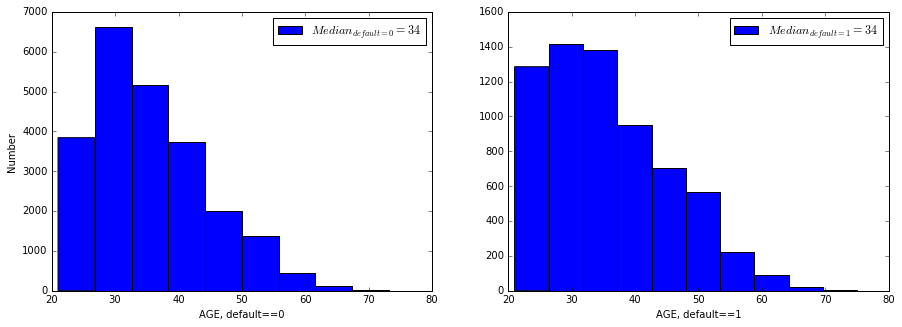

In [172]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(data_def0.AGE , label='$Median_{default=0} = %i$'%data_def0.AGE.median())
plt.xlabel('AGE, default==0')
plt.ylabel('Number')
plt.legend(loc='best')



plt.subplot(1,2,2)
plt.hist(data_def1.AGE, label='$Median_{default=1} = %i$'%data_def1.AGE.median())
plt.xlabel('AGE, default==1')
plt.legend(loc='best')

Построим доверительные интервалы для медиан и разностей наших выборок бутстрепом

In [173]:
def0_medians = np.median(get_bootstrap_samples(data_def0.AGE.values, 2000), axis=1)
def1_medians = np.median(get_bootstrap_samples(data_def1.AGE.values, 2000), axis=1)
delta_median = map(lambda x: x[0] - x[1], zip(def0_medians, def1_medians))
print ("95% confidence interval for AGE default=0 median:",  stat_intervals(def0_medians))
print ("95% confidence interval for AGE default=1 median:",  stat_intervals(def1_medians))
print ("95% confidence interval for AGE difference median:",  stat_intervals(delta_median))

('95% confidence interval for AGE default=0 median:', array([ 34.,  34.]))
('95% confidence interval for AGE default=1 median:', array([ 34.,  35.]))
('95% confidence interval for AGE difference median:', array([-1.,  0.]))


## Ответ:
Из-за пересечения доверительных интервалов, нулевую гипотезу об одинаковости медианных значений отвергнуть нельзя. Проверим статистическую значимость нашего результата с помощью критерия Манна-Уитни о раверстве медиан против обратной альтернативы

In [174]:
print mannwhitneyu(data_def0.AGE.values, data_def1.AGE.values, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.37250354348986159)


## Ответ:
Не можем отвергнуть нулевую гипотезу о равенстве медиан